In [9]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Load datasets
train_df = pd.read_csv('UNSW_NB15_training-set.csv')
test_df = pd.read_csv('UNSW_NB15_testing-set.csv')

# Combine train and test for consistent label encoding
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Drop columns with no use
combined_df = combined_df.drop(columns=['id'])  # 'id' is non-feature

# Label encode categorical columns
categorical_cols = ['proto', 'service', 'state']
le_dict = {}

for col in categorical_cols:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col].astype(str))
    le_dict[col] = le  # Save encoder for inverse transform if needed

# Now split back into train and test
train_encoded = combined_df.iloc[:len(train_df)].copy()
test_encoded = combined_df.iloc[len(train_df):].copy()

# Define features and labels
X_train = train_encoded.drop(columns=['label', 'attack_cat'])
y_train = train_encoded['label']

X_test = test_encoded.drop(columns=['label', 'attack_cat'])
y_test = test_encoded['label']

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"✅ Preprocessing done!\nOriginal shape: {X_train.shape} → PCA shape: {X_train_pca.shape}")


✅ Preprocessing done!
Original shape: (175341, 42) → PCA shape: (175341, 22)



📊 Final Results:
                 Model  Accuracy  Precision  Recall  F1 Score  \
0        Random Forest    0.8474     0.7931  0.9779    0.8759   
1                  SVM    0.8149     0.7502  0.9951    0.8555   
2  Logistic Regression    0.7637     0.7142  0.9518    0.8160   
3        Decision Tree    0.8437     0.8092  0.9372    0.8685   
4          Naive Bayes    0.7434     0.7044  0.9201    0.7979   

   Train Time (min)  
0            1.4450  
1            5.9383  
2            0.0127  
3            0.1123  
4            0.0014  


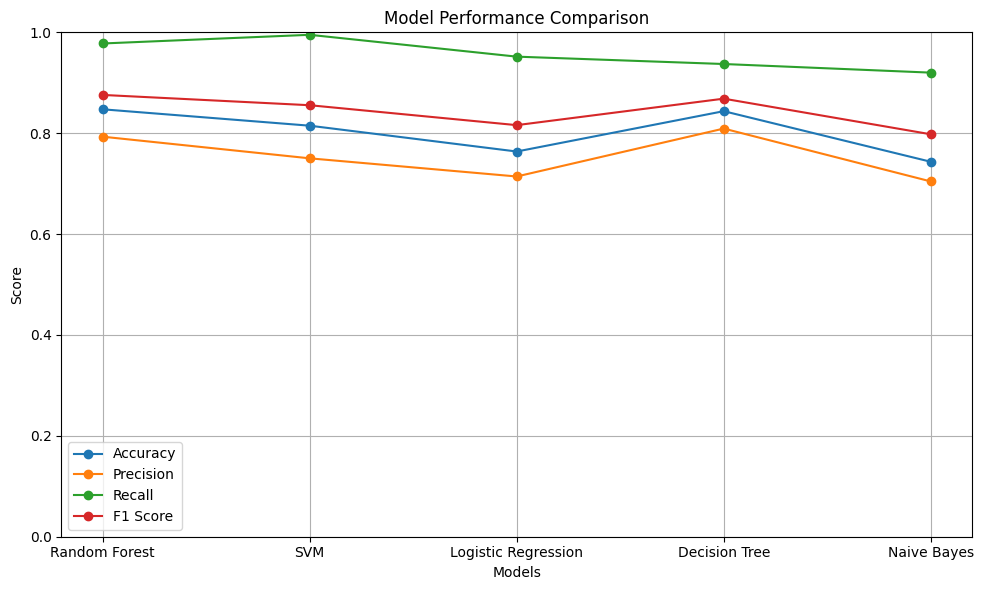

In [10]:
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

# Models to evaluate
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB()
}

results = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_pca, y_train)
    end_time = time.time()

    y_pred = model.predict(X_test_pca)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    train_time = (end_time - start_time) / 60  # in minutes

    results.append({
        'Model': name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4),
        'Train Time (min)': round(train_time, 4)
    })

# Create DataFrame
results_df = pd.DataFrame(results)
print("\n📊 Final Results:")
print(results_df)

# Save to CSV if needed
results_df.to_csv("model_comparison_results.csv", index=False)

# 📈 Line Chart Plotting
plt.figure(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for metric in metrics:
    plt.plot(results_df['Model'], results_df[metric], marker='o', label=metric)

plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
